In [53]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

%matplotlib inline

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #if you read an image with cv2.imread()
    
def canny(img, low_threshold=70, high_threshold=150):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices=None):
    Y_UPPER_POS_REGION = 0.625
    X_OFFSET_REG = 0.1
    Y_OFFSET_REG = .0833

    M_LOWER_LIMIT = 0.8
    M_UPPER_LIMIT = 1.2

    if vertices is None:
        
        img_w = img.shape[1]
        img_h = img.shape[0]

        y_pos = int(Y_UPPER_POS_REGION * img_h) #450
        x_center = int(img_w / 2)
        x_diff = .156
        ul_cut = int((1 - x_diff) * x_center) #Upper Left 
        ur_cut = int((1 + x_diff) * x_center) #Upper Right
        x_offset = int(X_OFFSET_REG * img_w) #120 
        y_offset = int(Y_OFFSET_REG * img_h) #60

        vertices = np.array([[(x_offset,img_h-y_offset), (ul_cut,y_pos), (ur_cut,y_pos), (img_w-x_offset,img_h-y_offset)]], dtype=np.int32)
        
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
        
    left_slopes = list()
    right_slopes = list()
    
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    Y_UPPER_POS_REGION = 0.625
    min_y = int(Y_UPPER_POS_REGION * img_h) #450

    max_y = img_h
    
    ll_start_pos = (img_w,img_h)
    rl_start_pos = (img_w, img_h)
    
    ll_end_pos = (img_w, 0)
    rl_end_pos = (0,0)

    x_center = int(img_w/2)
    
    #Calculate slope in an image
    for line in lines:

        for x1,y1,x2,y2 in line:
            
            m = (x2-x1) / (y2-y1)
            if m > 2. or m < -2. or math.isnan(m):
                #print("Extreme slope:", m, "pos:", line)
                continue

            if x1 < x_center and x2 < x_center:

                left_slopes.append(m)
                #print("LL slope:", m, "pos:", line)
                if ll_start_pos[1] > y1:
                    ll_start_pos = (x1, y1)
                    
                if ll_start_pos[1] > y2:
                    ll_start_pos = (x2, y2)
                
            elif x1 > x_center and x2 > x_center:
                right_slopes.append(m)
                #print("RL slope:", m, "pos:", line)
                if rl_start_pos[1] > y1:
                    rl_start_pos = (x1, y1)
                if rl_start_pos[1] > y2:
                    rl_start_pos = (x2, y2)
                                            
    avg_ll_slope = np.mean(left_slopes)
    if not math.isnan(avg_ll_slope) and len(left_slopes) > 0:
        #extrapolate to upper region
        ll_start_pos_x = int(avg_ll_slope * (min_y - ll_start_pos[1]) + ll_start_pos[0])
        ll_start_pos = (ll_start_pos_x, min_y)
        
        #extrapolate to below region
        ll_end_pos_x = int(avg_ll_slope * (max_y - ll_start_pos[1]) + ll_start_pos[0])
        ll_end_pos = (ll_end_pos_x, max_y)
        
        cv2.line(img, ll_start_pos, ll_end_pos, color, thickness)
    
    avg_rl_slope = np.mean(right_slopes)
    if not math.isnan(avg_rl_slope) and len(right_slopes) > 0:        
        #extrapolate to upper region
        rl_start_pos_x = int(avg_rl_slope * (min_y - rl_start_pos[1]) + rl_start_pos[0])
        rl_start_pos = (rl_start_pos_x, min_y)
        
        #extrapolate to below region
        rl_end_pos_x = int(avg_rl_slope * (max_y - rl_start_pos[1]) + rl_start_pos[0])
        rl_end_pos = (rl_end_pos_x, max_y)
        
        cv2.line(img, rl_start_pos, rl_end_pos, color, thickness)
            
    
def hough_lines(canny_img, rho=1, theta=np.pi/180, threshold=15, min_line_len=10, max_line_gap=4):

    lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((canny_img.shape[0], canny_img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(hough_img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, hough_img, β, λ)


def process_image(image):
    
    img_gray = grayscale(image)
    img_gauss = gaussian_blur(img_gray)
    img_canny = canny(img_gauss)
    
    img_canny_masked = region_of_interest(img_canny)    
    img_hough = hough_lines(img_canny_masked)
    img_rend = weighted_img(image, img_hough)
    return img_rend

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


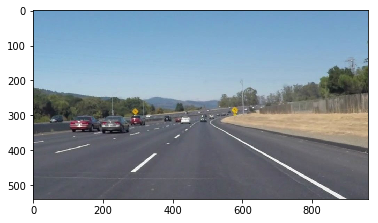

In [54]:
import os
filename = os.listdir('test_images/')
initial_img = mpimg.imread('test_images/' + filename[3])

print('This image is:', type(initial_img), 'with dimensions:', initial_img.shape)
plt.imshow(initial_img)

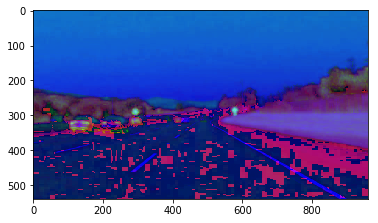

In [55]:
img_gray = grayscale(initial_img)
plt.imshow(img_gray)

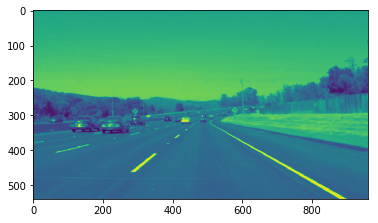

In [46]:
img_gauss = gaussian_blur(img_gray)
plt.imshow(img_gauss)

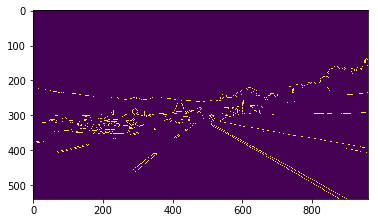

In [47]:
img_canny = canny(img_gauss)
plt.imshow(img_canny)

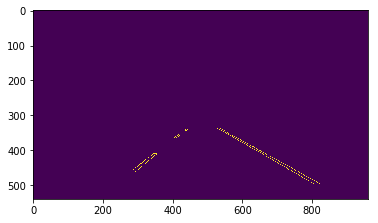

In [48]:
img_canny_masked = region_of_interest(img_canny)
plt.imshow(img_canny_masked)

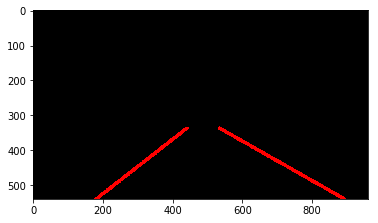

In [49]:
img_hough = hough_lines(img_canny_masked)
plt.imshow(img_hough)

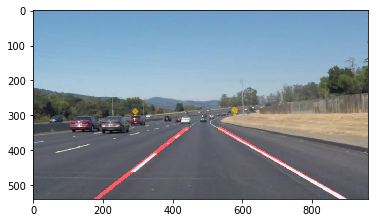

In [50]:
img_rend = weighted_img(initial_img, img_hough)
plt.imshow(img_rend)

This image is: <class 'numpy.ndarray'> with dimensions: (1440, 2560, 3)


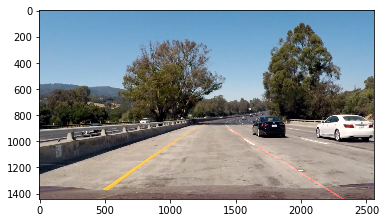

In [51]:
second_img = mpimg.imread('test_images/' + 'challenge3.jpg') #filename[8])
print('This image is:', type(initial_img), 'with dimensions:', second_img.shape)
proc_img = process_image(second_img)
plt.imshow(proc_img)

In [52]:
#file_name = 'solidWhiteRight.mp4'
#file_name = 'solidYellowLeft.mp4'
file_name = 'challenge.mp4'
vid_output = 'test_videos_output/' + file_name
clip1 = VideoFileClip('test_videos/' + file_name)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(vid_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:14<00:00, 17.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.18 s, sys: 2.02 s, total: 7.19 s
Wall time: 16.5 s
